# Pooling and Blending

This notebook presents an overview of bilinear pooling and blending problems in the context of a simple milk blending operation. The essential non-convex nature of the problem is demonstrated, and the two basic formulations (the P- and Q- parameterizations) are shown.

In [37]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Bibliographic Notes

The pooling and blending is a large scale, high value, fundamental problem of logistics for the process and refining industries. The prototypical examples are the pooling and blending crude oils to meet the feed stock constraints of refineries, and for the pooling of refinery products for pipeline delivery to distribution terminals. Un

Haverly (1978) is a commonly cited small benchmark problem for the pooling and blending of sulfurous fuels. 

> Haverly, C. A. (1978). Studies of the behavior of recursion for the pooling problem. Acm sigmap bulletin, (25), 19-28. https://dl.acm.org/doi/pdf/10.1145/1111237.1111238

There is an extensive literature on pooling and blending. The following encyclopedia entry explains the history of the pooling problem, how it leads to multiple local minima and other pathological behaviors, and approaches to finding practical solutions.

> Visweswaran, V. (2009). MINLP: Applications in Blending and Pooling Problems. https://link.springer.com/referenceworkentry/10.1007/978-0-387-74759-0_375

Recent research overviews include


> Misener, R., & Floudas, C. A. (2009). Advances for the pooling problem: Modeling, global optimization, and computational studies. Applied and Computational Mathematics, 8(1), 3-22. https://www.researchgate.net/profile/Ruth-Misener/publication/242290955_Advances_for_the_pooling_problem_Modeling_global_optimization_and_computational_studies_Survey/links/0046352e7d1dfeb40f000000/Advances-for-the-pooling-problem-Modeling-global-optimization-and-computational-studies-Survey.pdf

> Gupte, A., Ahmed, S., Dey, S. S., & Cheon, M. S. (2013). Pooling problems: relaxations and discretizations. School of Industrial and Systems Engineering, Georgia Institute of Technology, Atlanta, GA. and ExxonMobil Research and Engineering Company, Annandale, NJ. http://www.optimization-online.org/DB_FILE/2012/10/3658.pdf

The current state-of-the-art appears to be a formulation of the pooling problem is a mixed-integer quadratically-constrained quadratic optimization on a given network.

> Ceccon, F., & Misener, R. (2022). Solving the pooling problem at scale with extensible solver GALINI. Computers & Chemical Engineering, 107660. https://arxiv.org/pdf/2105.01687.pdf

Applications for pooling and blending are probably underappreciated. In particular, what role might pooling and blending problems have in projects like the World Food Programme (WFP)?

## Example: Pooling Milk for Wholesale Blending and Distribution

A bulk distributor supplies several customers with deliveries of raw milk purchased from local farms. The deliveries may be blended to meet the minimum required milk fat content specified by each customer.

The distributor has found lower cost sources of raw milk from several farms located a long distance away. The distant farms produce grades of milk that may be blended with local sources. The distributor, however, has just one truck with a single tank available to transport raw milk from the distant farms to the blending facility. Because of this, any milk purchased from the distant farms would be mixed together in the tank before transport to the blending station. The contents of the tank is the "pool" referred to in pooling problems.

The situation is illustrated in the following diagram where arrows show the flow and blending of milk supplies.

![](milk-pooling.dio.png)


What should the distributor do?

* Option 1. Do nothing, continue operating the business as usual with local suppliers.

* Option 2. Buy a second truck so raw milk can be transported from the remote farms to the blending facility without pooling.

* Option 3. Pool raw milk from the remote farms into a single tank for truck transport to the blending facility.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

customers = pd.DataFrame({
    "Customer A": {"fat": 0.0445, "price": 52.0, "demand": 6000.0},
    "Customer B": {"fat": 0.030, "price": 48.0, "demand": 2500.0}
}).T

suppliers = pd.DataFrame({
    "Farm A": {"fat": 0.045, "cost": 45.0, "location": "local"},
    "Farm B": {"fat": 0.030, "cost": 42.0, "location": "local"},
    "Farm C": {"fat": 0.033, "cost": 37.0, "location": "remote"},
    "Farm D": {"fat": 0.050, "cost": 45.0, "location": "remote"}},
    ).T

local_suppliers = suppliers[suppliers["location"]=="local"]
remote_suppliers = suppliers[suppliers["location"]=="remote"]

print("\nCustomers")
display(customers)

print("\nLocal Suppliers")
display(local_suppliers)

print("\nRemote Suppliers")
display(remote_suppliers)



Customers


,fat,price,demand
Customer A,0.0445,52.0,6000.0
Customer B,0.0300,48.0,2500.0



Local Suppliers


,fat,cost,location
Farm A,0.045,45.0,local
Farm B,0.03,42.0,local



Remote Suppliers


,fat,cost,location
Farm C,0.033,37.0,remote
Farm D,0.05,45.0,remote


## Option 1. Business as usual

Business as usual for the milk distributor is to blend supplies from the two local farms to meet customer requirements. Let $L$ designate the set of local suppliers, and let $C$ designate the set of customers. The decision variable $x_{l, c}$ is the amount of milk from local supplier $l\in L$ mixed into the blend for customer $c\in C$.

The distributor's objectives is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
\end{align*}
$$ 

where the notation $(l,c)\ \in\ L\times C$ indicates a summation over the cross-product of two sets. A useful interpretation is that $(l,c)\ \in\ L\times C$ describes all ways of delivering milk from $l$ to $c$. Each term $(\text{price}_c - \text{cost}_l)$ is then the profit earned by delivering one unit of milk from $l\in L$ to $c\in C$.

The amount of milk delivered to each customer $c\in C$ can not exceed the demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

The milk blend delivered to each customer $c\in C$ must meet the minimum product quality requirement for milk fat. Assuming linear blending, the model becomes

$$
\begin{align*}
\sum_{(l,c)\ \in\ L \times C} \text{conc}_{l} x_{l,c} & \geq \text{conc}_{c} \sum_{l\in L} x_{l, c} & \forall c \in C
\end{align*}
$$

This is a standard linear blending problem.

In [39]:
import pyomo.environ as pyo

q = "fat"

m = pyo.ConcreteModel()

# define sources and customers
m.L = pyo.Set(initialize=local_suppliers.index)
m.C = pyo.Set(initialize=customers.index)
m.L2C = m.L * m.C

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define local -> customer flowrates
m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L2C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.x[l, c] for l in m.L) <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def quality(m, c):
    return sum(m.x[l, c] * suppliers.loc[l, q] for l in m.L) >= sum(m.x[l, c] for l in m.L) * customers.loc[c, q]

pyo.SolverFactory('cbc').solve(m)

print(f"\nprofit = {m.profit():0.2f}\n")

X = pd.DataFrame([[l, c, round(m.x[l, c](), 1)] for l, c in m.L2C], columns = ["supplier", "customer", "blend"])
X = X.pivot_table(index="customer", columns="supplier")

X["fat"]  = sum(X.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in m.L)/X.sum(axis=1)
X["Total"] = X.sum(axis=1)
display(X)



profit = 57600.00



blend             fat      Total
supplier    Farm A  Farm B                   
customer                                     
Customer A  5800.0   200.0  0.0445  6000.0445
Customer B     0.0  2500.0  0.0300  2500.0300

## Option 2. Buy an additional truck

The current profit earned is 57,600 using only local suppliers. Before considering pooling, however, the distributor may wish to know the maximum profit potential that could be earned if the remote suppliers could be blended as if they were local suppliers. This would require acquiring and operating a separate transport for each remote supplier, so it is worth knowing if the additional profit earned would justify the additional expense.

The model used above applies by extending the set of suppliers to include both local and remote farms. The required changes are noted in the cell below.

In [40]:
import pyomo.environ as pyo

q = "fat"

m = pyo.ConcreteModel()

# define sources and customers
m.R = pyo.Set(initialize=remote_suppliers.index)       # <== set of remote suppliers
m.L = m.R | pyo.Set(initialize=local_suppliers.index)  # <== treat remote suppliers same a local suppliers
m.C = pyo.Set(initialize=customers.index)
m.L2C = m.L * m.C

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define local -> customer flowrates
m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L2C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.x[l, c] for l in m.L) <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def quality(m, c):
    return sum(m.x[l, c] * suppliers.loc[l, q] for l in m.L) >= sum(m.x[l, c] for l in m.L) * customers.loc[c, q]

pyo.SolverFactory('cbc').solve(m)

print(f"\nprofit = {m.profit():0.2f}\n")

X = pd.DataFrame([[l, c, round(m.x[l, c](), 1)] for l, c in m.L2C], columns = ["supplier", "customer", "blend"])
X = X.pivot_table(index="customer", columns="supplier")

X["fat"]  = sum(X.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in m.L)/X.sum(axis=1)
X["Total"] = X.sum(axis=1)
display(X)



profit = 85029.41



blend                            fat      Total
supplier   Farm A Farm B  Farm C  Farm D                   
customer                                                   
Customer A    0.0    0.0  1941.2  4058.8  0.0445  6000.0445
Customer B    0.0    0.0  2500.0     0.0  0.0330  2500.0330

The calculations show that purchasing raw milk from the remote farms can significantly increases profits. The blending plan, however, requires transporting 4,618 units of raw milk from farms C, and additional 3,882 units of raw milk from farm C.  The plan does not allow pooling these sources prior to transport, otherwise they would somehow need to be "unblended" to meet the minimum quality requirement for customer A.

## Option 3. Pool delivery from remote farms

Analysis of the first two options shows there is significant additional profit to be earned by purchasing raw milk from the remote farms. But the option requires acquiring and operating an additional truck to keep the materials separate for later blending. Blending at the remote location is also not an option because that plan, too, would require separate transport. 

The natural question is whether the one existing truck could transport a pool of raw milk from remote farms C and D that could be blended with raw milk from local farms A and B to meet customer requirements. The profit potential may be reduced due to pooling, but it may still be a better option than adding additional operating expense.

There are a number of formulations of this problem. This analysis will use a version the "p-parameterization" where the composition of the pool is a decision variable. Here that variable will be called $f$.

Other decision variables are also needed. Variable $y_c$ is the amount of the pool used in the blend delivered to customer $c\in C$. Variable $z_r$ is the amount of raw milk purchased from remote farm $r$ and included in the pool.

Again, the objective is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
+ \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r z_{r}
\end{align*}
$$

where additional terms are included for the cost of raw milk included in the pool, and customer revenue earned from use of the pool. The product delivered to each customer can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

A  incoming and outgoing flows to the pool must balance.

$$
\begin{align*}
\sum_{r\in R}z_{r} & = \sum_{c\in C} y_{c} \\
\end{align*}
$$

The average milk fat composition of the pool, $f$, must satisfy an overall balance on milk fat entering the pool from the remote farms and the milk fat delivered to customers.

$$
\begin{align*}
\sum_{r\in R}\text{conc}_{r} z_{r}  & = \underbrace{f \sum_{c\in C} y_{c}}_{\text{bilinear}}
\end{align*}
$$

Finally, the minimum milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\underbrace{f y_{c}}_{\text{bilinear}}  + \sum_{(l,c)\ \in\ L \times C} x_{l,c} \text{conc}_{l} 
& \geq \text{conc}_{c} (\sum_{l\in L} x_{l, c} + y_{c})
& \forall c \in C
\end{align*}
$$

The last two constraints include bilinear terms from the project of decision variable $f$ with decision variables $y_c$ for all $c\in C$. 

The bilinear terms have a profound consequence on the nature of the optimization problem. To demonstrate, the following cell creates a linear program to maximize profit as a function of $f$, then explores how profit changes as a function of parameter $f$.

In [41]:
import pyomo.environ as pyo

def p_milk(f=0, q="fat"):
    
    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.z[r]*suppliers.loc[r, "cost"] for r in m.R)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.z[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.z[r] for r in m.R) == f * sum(m.y[c] for c in m.C)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return f * m.y[c] + sum(suppliers.loc[l, q] * m.x[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.x[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('cbc').solve(m)
    
    return m

f = np.linspace(0.025, 0.055, 200)
p = [p_milk(f).profit() for f in f]

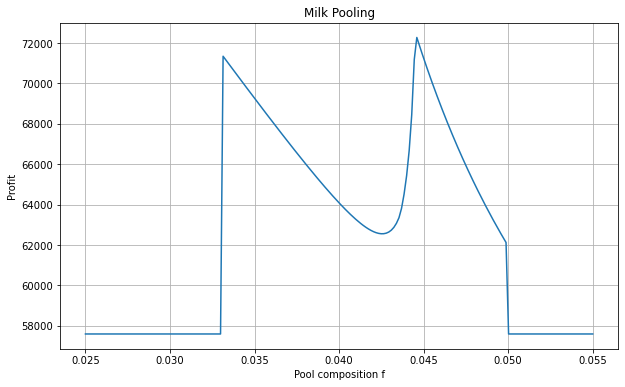

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(f, p)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition f")
ax.set_ylabel("Profit")
ax.grid(True)

The plot demonstrates bilinear constraints and parameter values resulting in multiple local maxima and a saddle point. These are features encountered non-convex optimization.

## Suggested Exercises

This simple model demonstrates practical issues that arise in modeling the non-convex problems. Take time explore the behavior of the model to parameter changes and the nature of the solution. 

1. Examine the model data and explain why the enhanced profits are observed only for a particular range of values in $f$.

2. Think carefully about the non-convex behavior observed in the plot of profit versus parameter f.  Why are the local maxima located where they are, and how are they related to problem data? Test your hypothesis by changing the problem data.  What happens when the product specification for Customer A is set equal to 0.045? What happens when it is set to 0.04?

3. Rather than scan values of $f$ to look for an optimum, revise the Pyomo model to find the optimum value. This will be a nonlinear optimization, and a challenging one at that.  Try using 'cbc', 'gurobi_direct', 'ipopt', and 'bonmin' to find a solution. Did you find a solver that could solve this nonlinear problem?

4. The above analysis assumed unlimited transport. If the truck turns out to have a limit of 4,000 units of milk, write the mathematical constraint necessary to introduce that limit into the model. Add that constraint to the Pyomo model and discuss the impact on profit.

## Reformulating the model (Ben-Tal, 1994)

The model presented above introduced a decision variable $f$ corresponding to the pool composition. Essentially the choice of $f$ decomposes the problem into two parts ... the formulation of an blending pool from the remote farms with composition $f$, and the blending of deliveries to the customers using a combination of the pool and additional supplies purchased from local farms. 

An alternative formulation is to introduce a different set of decision variables, here called $w_r \geq 0$, that described the fraction of the pool that is obtained from remote farm $r\in R$. The relationships between variables $z_r$ and $y_c$ are then given by

$$
\begin{align*}
z_r & = w_r \sum_{c\in C} y_c & \forall r \in R
\end{align*}
$$

The overall balance of inputs and outputs on the pool is given by

$$
\begin{align*}
\sum_{r\in R} w_r & = 1
\end{align*}
$$

Working with the objective function

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
    + \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r z_{r} \\
& = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c} 
    + \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r w_r \sum_{c\in C}y_c \\
\end{align*}
$$

which introduces bilinear terms into the objective function.

$$
\begin{align*}
\implies \text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_l - \text{cost}_c) x_{l,c} 
    + \sum_{c\in C} \left(\text{price}_c - \sum_{r\in R} \text{cost}_r w_r \right)y_{c}
\end{align*}
$$

As before, the product delivered to each customer can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

A incoming and outgoing flows to the pool must balance.

$$
\begin{align*}
\sum_{r\in R}w_{r} & =  1 \\
\end{align*}
$$

The average milk fat composition of the pool, $f$, must satisfy an overall balance on milk fat entering the pool from the remote farms and the milk fat delivered to customers. Finally, the minimum milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\sum_{l\in L} \left(\text{conc}_c - \text{conc}_l\right) x_{l,c} +
\left(\sum_{r\in R} \text{conc}_r w_r - \text{conc}_c\right) y_c & \geq 0 & \forall c\in C
\end{align*}
$$

In this formulation bilinear terms appear in the objective function and composition constraints. The following cells plot the value of the objective for fixed values of $w_{\text{Farm C}}$ where $w_{\text{Farm D}} = 1 - w_{\text{Farm C}}$.

In [43]:
import pyomo.environ as pyo

def q_milk(w=0, q="fat"):
    
    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    
    m.w = pyo.Param(m.R, mutable=True)
    m.w["Farm C"] = w
    m.w["Farm D"] = 1 - w

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum( m.y[c]*(customers.loc[c, "price"] - sum(m.w[r] * suppliers.loc[r, "cost"] for r in m.R)) for c in m.C)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
                 + (sum(suppliers.loc[r, q] * m.w[r] for r in m.R) - customers.loc[c, q]) * m.y[c] >= 0

    pyo.SolverFactory('cbc').solve(m)
    
    return m

w = np.linspace(0.0, 1.0, 200)
p = [q_milk(w).profit() for w in w]

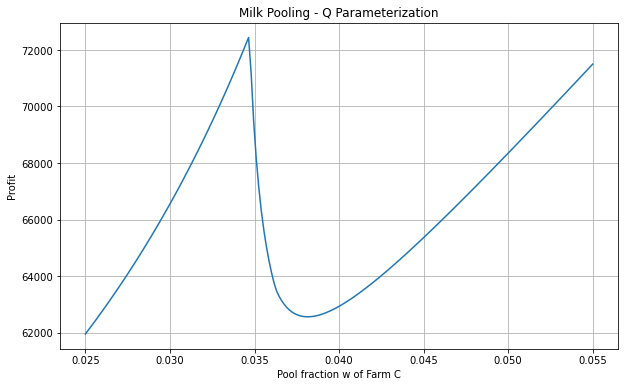

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(f, p)
ax.set_title("Milk Pooling - Q Parameterization")
ax.set_xlabel("Pool fraction w of Farm C")
ax.set_ylabel("Profit")
ax.grid(True)

As for the case of the P-parameterization, the bilinear Q-parameterization exhibits local maxima and saddle points. Nevertheless, the received wisdom is that the Q-parameterization yields higher performance and less likely to report a local maxima as solution.

## Nonlinear optimization

The following cells demonstrate the solution of the milk pooling problem using both the P- and Q-parameterizations. 

In [55]:
import pyomo.environ as pyo

def p_milk_opt(q="fat"):
    
    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(bounds=(0, 1))

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.z[r]*suppliers.loc[r, "cost"] for r in m.R)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.z[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.z[r] for r in m.R) == m.f * sum(m.y[c] for c in m.C)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return m.f * m.y[c] + sum(suppliers.loc[l, q] * m.x[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.x[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = p_milk_opt()
print(m.profit())
m.x.display()
m.y.display()
m.z.display()

71500.00072166749
x : Size=4, Index=x_index
    Key                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('Farm A', 'Customer A') :     0 : 5750.000056665484 :  None : False : False : NonNegativeReals
    ('Farm A', 'Customer B') :     0 :               0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer A') :     0 :               0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer B') :     0 :               0.0 :  None : False : False : NonNegativeReals
y : Size=2, Index=C
    Key        : Lower : Value              : Upper : Fixed : Stale : Domain
    Customer A :     0 : 250.00000334381687 :  None : False : False : NonNegativeReals
    Customer B :     0 :  2500.000025018958 :  None : False : False : NonNegativeReals
z : Size=2, Index=R
    Key    : Lower : Value             : Upper : Fixed : Stale : Domain
    Farm C :     0 : 2750.000028372415 :  None : False : False : NonNegativeReals
    Farm D :     0 : 

In [56]:
import pyomo.environ as pyo

def q_milk_opt(q="fat"):
    
    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.w = pyo.Var(m.R, bounds=(0, 1))

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum( m.y[c]*(customers.loc[c, "price"] - sum(m.w[r] * suppliers.loc[r, "cost"] for r in m.R)) for c in m.C)
    
    @m.Constraint()
    def pool_balance(m):
        return sum(m.w[r] for r in m.R) == 1

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
                 + (sum(suppliers.loc[r, q] * m.w[r] for r in m.R) - customers.loc[c, q]) * m.y[c] >= 0

    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = q_milk_opt()
print(m.profit())
m.w.display()
m.x.display()
m.y.display()

71500.00069370153
w : Size=2, Index=R
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    Farm C :     0 :   1.0 :     1 : False : False :  Reals
    Farm D :     0 :   0.0 :     1 : False : False :  Reals
x : Size=4, Index=x_index
    Key                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('Farm A', 'Customer A') :     0 : 5750.000060205816 :  None : False : False : NonNegativeReals
    ('Farm A', 'Customer B') :     0 :               0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer A') :     0 :               0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer B') :     0 :               0.0 :  None : False : False : NonNegativeReals
y : Size=2, Index=C
    Key        : Lower : Value             : Upper : Fixed : Stale : Domain
    Customer A :     0 : 249.9999998034846 :  None : False : False : NonNegativeReals
    Customer B :     0 : 2500.000025018958 :  None : False : False : NonNegativeReal

## Convexification

In [105]:
import pyomo.environ as pyo


m = pyo.ConcreteModel()

# define sources 
m.L = pyo.Set(initialize=local_suppliers.index)
m.R = pyo.Set(initialize=remote_suppliers.index)

# define customers
m.C = pyo.Set(initialize=customers.index)

# define flowrates
m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
m.y = pyo.Var(m.C, bounds = lambda m, r: (0, customers.loc[r, "demand"]))
m.w = pyo.Var(m.R, bounds=(0, 1))

@m.Objective(sense=pyo.maximize)
def profit(m):
    return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
           + sum( m.y[c]*(customers.loc[c, "price"] - sum(m.w[r] * suppliers.loc[r, "cost"] for r in m.R)) for c in m.C)

@m.Constraint()
def pool_balance(m):
    return sum(m.w[r] for r in m.R) == 1

@m.Constraint(m.C)
def customer_demand(m, c):
    return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def customer_quality(m, c):
    return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
             + (sum(suppliers.loc[r, q] * m.w[r] for r in m.R) - customers.loc[c, q]) * m.y[c] >= 0

pyo.SolverFactory('ipopt').solve(m)

print(m.profit())
#m.w.display()
#m.x.display()
#m.y.display()

for c in m.C:
    print(f"{c}  {m.y[c].lower} {m.y[c].upper:8.2f} {m.y[c]():8.2f}")
    
for r in m.R:
    print(f"{r}  {m.w[r].lower} {m.w[r].upper:8.2f} {m.w[r]():8.2f}")

71500.0004185334
Customer A  0  6000.00   250.00
Customer B  0  2500.00  2500.00
Farm C  0     1.00     1.00
Farm D  0     1.00     0.00


In [73]:
m.y["Customer A"].lower

0